# Walmart Analyses Project

### Problem Statment : A retail store that has multiple outlets across the country are facing issues in managing the inventory - to match the demand with respect to supply.
- In this notebook i have done analyses on walmart stores's weekly sales and found some importent insist.
- I have used 3 models ARIMA, SARIMAX, and at last of notebook i have used exponential smoothing for prediction of sales.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

import warnings
warnings.filterwarnings("ignore")


In [2]:
data = pd.read_csv('Walmart.csv',parse_dates=['Date'],index_col='Date')

In [3]:
data.index = pd.to_datetime(data.index,format='%d-%m-%Y')

In [4]:
data.head(3)

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106


In [5]:
data.columns

Index(['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment'],
      dtype='object')

# Removing Outliers with copy a of data 

In [6]:
df_no_outliers_iqr = data.copy()

features1 = ['Weekly_Sales', 'Temperature', 'Unemployment']

for col in features1:
    q1 = df_no_outliers_iqr[col].quantile(0.25)
    q3 = df_no_outliers_iqr[col].quantile(0.75)
    iqr = q3 - q1

    # Filter the DataFrame to keep values within 1.5 times the IQR
    df_no_outliers_iqr = df_no_outliers_iqr[
        (df_no_outliers_iqr[col] >= (q1 - 1.5 * iqr)) &
        (df_no_outliers_iqr[col] <= (q3 + 1.5 * iqr))
    ]


In [7]:
df_no_outliers_iqr[df_no_outliers_iqr['Store'] == 1]

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,,
2010-02-05,1,1643690.90,0,42.31,2.572,211.096358,8.106
2010-02-12,1,1641957.44,1,38.51,2.548,211.242170,8.106
2010-02-19,1,1611968.17,0,39.93,2.514,211.289143,8.106
2010-02-26,1,1409727.59,0,46.63,2.561,211.319643,8.106
2010-03-05,1,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...
2012-09-28,1,1437059.26,0,76.08,3.666,222.981658,6.908
2012-10-05,1,1670785.97,0,68.55,3.617,223.181477,6.573
2012-10-12,1,1573072.81,0,62.99,3.601,223.381296,6.573


In [8]:
data.columns

Index(['Store', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price',
       'CPI', 'Unemployment'],
      dtype='object')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6435 entries, 2010-02-05 to 2012-10-26
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Weekly_Sales  6435 non-null   float64
 2   Holiday_Flag  6435 non-null   int64  
 3   Temperature   6435 non-null   float64
 4   Fuel_Price    6435 non-null   float64
 5   CPI           6435 non-null   float64
 6   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 402.2 KB


In [10]:
data.corr(numeric_only=True)

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
Store,1.000000e+00,-0.335332,-4.386841e-16,-0.022659,0.060023,-0.209492,0.223531
Weekly_Sales,-3.353320e-01,1.000000,3.689097e-02,-0.063810,0.009464,-0.072634,-0.106176
Holiday_Flag,-4.386841e-16,0.036891,1.000000e+00,-0.155091,-0.078347,-0.002162,0.010960
Temperature,-2.265908e-02,-0.063810,-1.550913e-01,1.000000,0.144982,0.176888,0.101158
Fuel_Price,6.002295e-02,0.009464,-7.834652e-02,0.144982,1.000000,-0.170642,-0.034684
CPI,-2.094919e-01,-0.072634,-2.162091e-03,0.176888,-0.170642,1.000000,-0.302020
Unemployment,2.235313e-01,-0.106176,1.096028e-02,0.101158,-0.034684,-0.302020,1.000000


In [11]:
data.isnull().sum()

Store           0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [12]:
data.duplicated().sum()

0

In [13]:
# Basic statistics for each column
column_stats = data.describe()

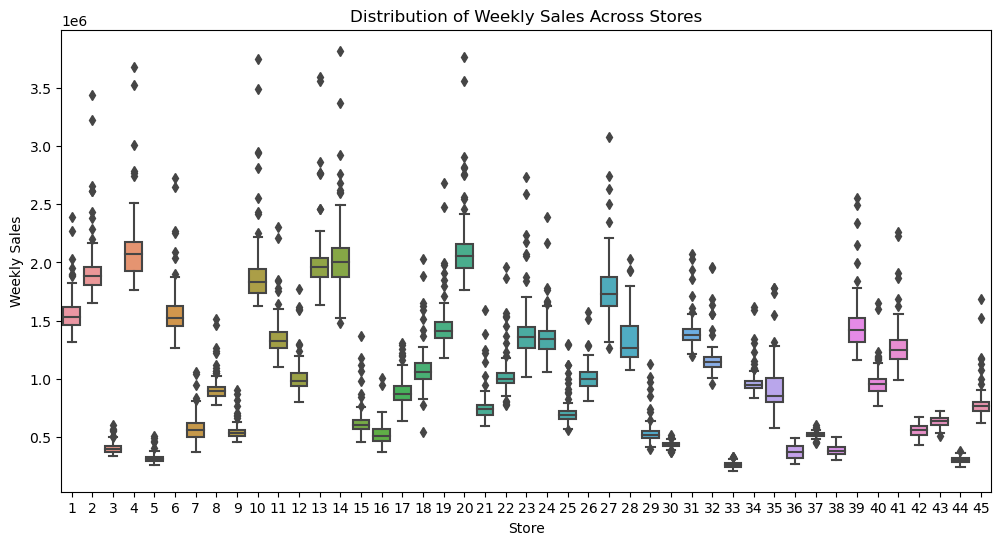

In [14]:
# Visualize distribution of weekly sales for each store
plt.figure(figsize=(12, 6))
sns.boxplot(x='Store', y='Weekly_Sales', data=data)
plt.title('Distribution of Weekly Sales Across Stores')
plt.xlabel('Store')
plt.ylabel('Weekly Sales')
plt.show()

In [15]:
# Proportion of holiday weeks vs. non-holiday weeks
holiday_proportion = data['Holiday_Flag'].value_counts(normalize=True) * 100
print("Proportion of Holiday Weeks vs. Non-Holiday Weeks:")
print(holiday_proportion)

Proportion of Holiday Weeks vs. Non-Holiday Weeks:
Holiday_Flag
0    93.006993
1     6.993007
Name: proportion, dtype: float64


# Observation : 
- It appears that approximately 93.01% of the weeks in your dataset are non-holiday weeks (Holiday_Flag = 0), while approximately 6.99% of the weeks are holiday weeks (Holiday_Flag = 1).

- This proportion indicates that non-holiday weeks are much more common in the dataset compared to holiday weeks. It's essential to consider this proportion when analyzing the impact of holidays on weekly sales and when building forecasting models, as the frequency of holiday occurrences can significantly affect sales patterns.

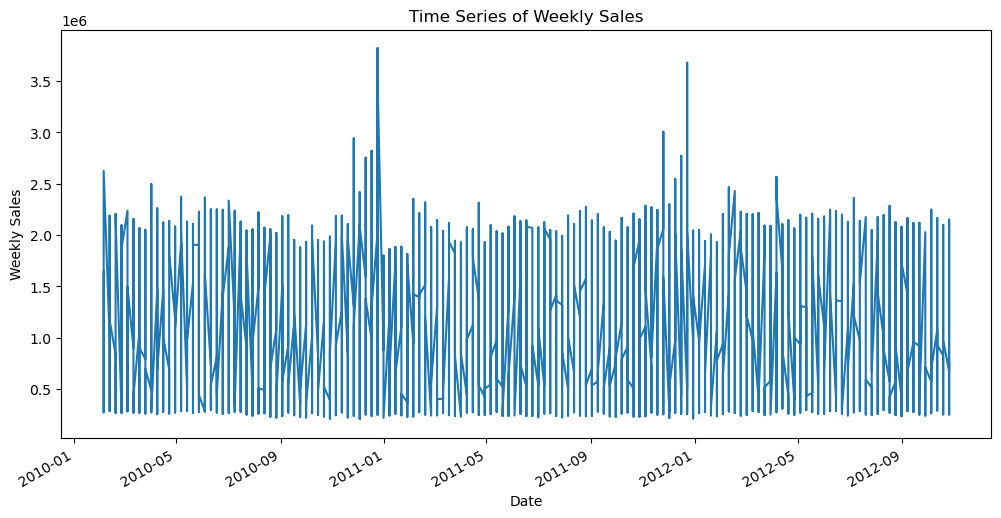

In [16]:
# Visualize time series of weekly sales
plt.figure(figsize=(12, 6))
data['Weekly_Sales'].plot()
plt.title('Time Series of Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.show()

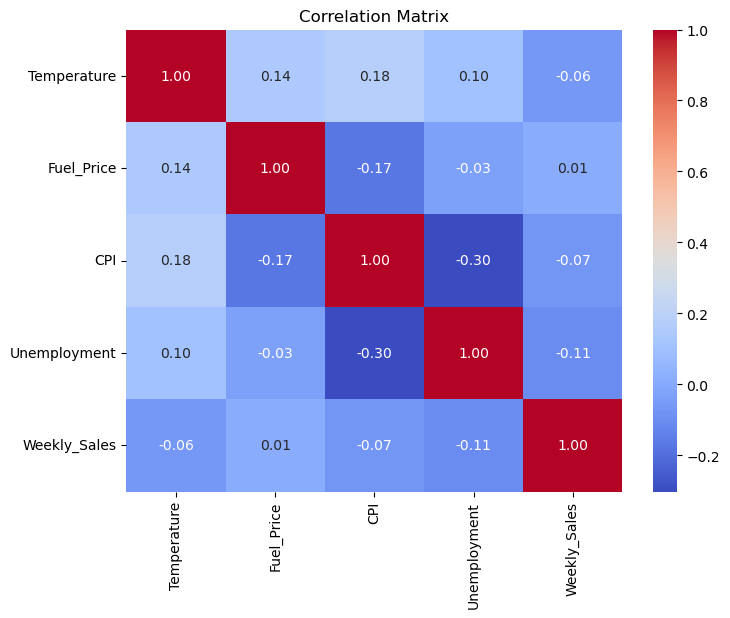

In [17]:
# Correlation matrix between economic indicators and weekly sales
economic_indicators = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
correlation_matrix = data[economic_indicators + ['Weekly_Sales']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [18]:
# Hypothesis testing for sales during holiday vs. non-holiday weeks (example)

holiday_sales = data[data['Holiday_Flag'] == 1]['Weekly_Sales']
non_holiday_sales = data[data['Holiday_Flag'] == 0]['Weekly_Sales']
t_stat, p_value = stats.ttest_ind(holiday_sales, non_holiday_sales)
print("T-Statistic:", t_stat)
print("P-Value:", p_value)


T-Statistic: 2.9608919093259036
P-Value: 0.003078699263818616


## Observation :

The t-statistic and p-value obtained from the t-test analysis provide insights into whether there is a statistically significant difference in sales during holiday weeks compared to non-holiday weeks.

- The t-statistic measures the difference between the means of the two groups (holiday sales and non-holiday sales) relative to the variance within the groups. A higher t-statistic indicates a larger difference between the means.

- The p-value indicates the probability of observing the data given that the null hypothesis (no difference in means) is true. A smaller p-value suggests stronger evidence against the null hypothesis.

In this case:

- The t-statistic is approximately 2.961.
- The p-value is approximately 0.0031.
With such a low p-value (less than 0.05), we can reject the null hypothesis and conclude that there is a statistically significant difference in sales between holiday weeks and non-holiday weeks. This suggests that holidays have a significant impact on sales at Walmart.

# Remove outliers using the Interquartile Range (IQR) method

In [19]:
# Remove outliers using the (IQR) method
def remove_outliers_iqr(df, columns):
    df_no_outliers = df.copy()
    for col in columns:
        q1 = df_no_outliers[col].quantile(0.25)
        q3 = df_no_outliers[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        df_no_outliers = df_no_outliers[(df_no_outliers[col] >= lower_bound) & (df_no_outliers[col] <= upper_bound)]
    return df_no_outliers


In [20]:
# Columns for outlier removal
columns_to_remove_outliers = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

# Remove outliers
data_no_outliers = remove_outliers_iqr(data, columns_to_remove_outliers)

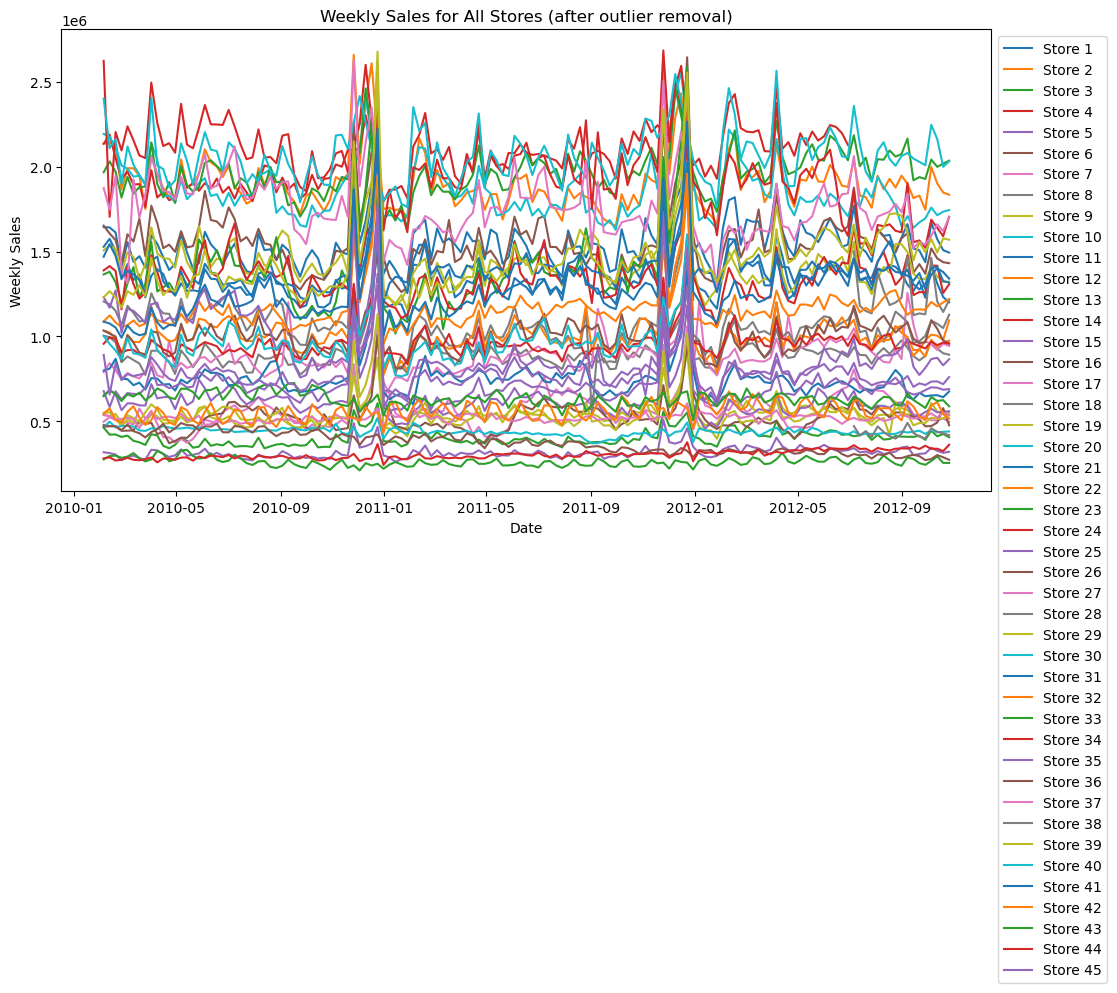

In [21]:
# Visualize weekly sales of all stores
plt.figure(figsize=(12, 6))
for store_id in data_no_outliers['Store'].unique():
    store_data = data_no_outliers[data_no_outliers['Store'] == store_id]
    plt.plot(store_data.index, store_data['Weekly_Sales'], label=f'Store {store_id}')

plt.title('Weekly Sales for All Stores (after outlier removal)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

 # Question related to business

# Q1). If the weekly sales are affected by the unemployment rate, if yes - which stores are suffering the most ?

Top Stores Most Affected by Unemployment Rate:
    Store       level_1  Unemployment
0       1  Weekly_Sales     -0.097955
1       2  Weekly_Sales      0.066325
2       3  Weekly_Sales     -0.230413
3       4  Weekly_Sales     -0.337015
4       5  Weekly_Sales     -0.207043
5       6  Weekly_Sales      0.044251
6       7  Weekly_Sales     -0.165382
7       8  Weekly_Sales     -0.052580
8       9  Weekly_Sales     -0.191534
9      10  Weekly_Sales      0.131908
10     11  Weekly_Sales     -0.020339
11     12  Weekly_Sales     -0.009286
12     13  Weekly_Sales     -0.171633
13     14  Weekly_Sales      0.210786
14     15  Weekly_Sales      0.078905
15     16  Weekly_Sales     -0.070864
16     17  Weekly_Sales     -0.263600
17     18  Weekly_Sales      0.139179
18     19  Weekly_Sales      0.101464
19     20  Weekly_Sales     -0.095341
20     21  Weekly_Sales      0.218367
21     22  Weekly_Sales      0.039043
22     23  Weekly_Sales     -0.077169
23     24  Weekly_Sales     -0.012261
24 

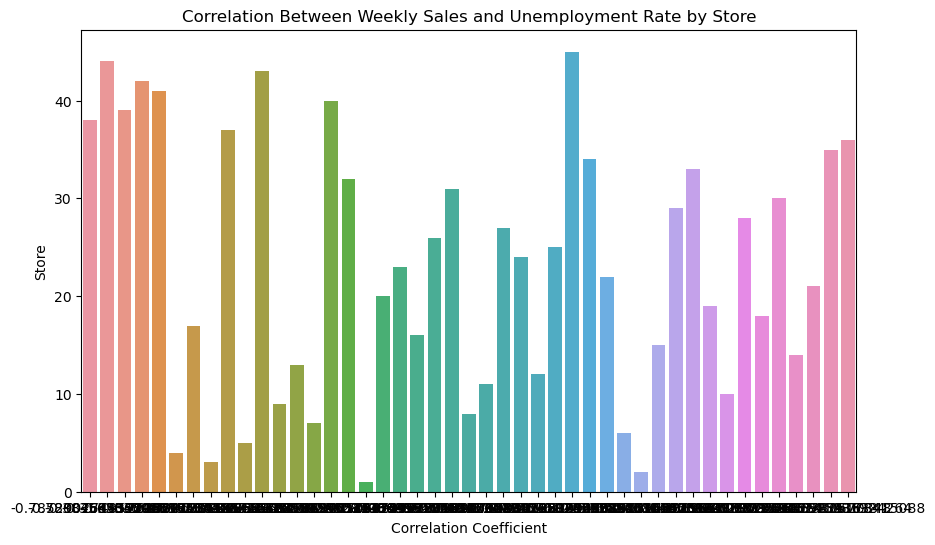

In [22]:
# Calculate correlation between weekly sales and unemployment rate for each store
store_correlation = data.groupby('Store')[['Weekly_Sales', 'Unemployment']].corr().iloc[0::2, -1]

# Sort stores by correlation coefficient
stores_most_affected = store_correlation.abs().sort_values(ascending=False).index

# Convert MultiIndex to DataFrame
store_correlation_df = store_correlation.reset_index()

# Print correlation coefficients for the top stores
print("Top Stores Most Affected by Unemployment Rate:")
print(store_correlation_df)

# Visualize correlation coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x='Unemployment', y='Store', data=store_correlation_df)
plt.title('Correlation Between Weekly Sales and Unemployment Rate by Store')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Store')
plt.show()

In [23]:
# Assuming 'data' is your DataFrame containing Walmart sales data

# Calculate correlation between weekly sales and unemployment rate for each store
store_correlation = data.groupby('Store')[['Weekly_Sales', 'Unemployment']].corr().iloc[0::2, -1]

# Print correlation coefficients for each store
for store_id in data['Store'].unique():
    try:
        correlation_coefficient = store_correlation.loc[(store_id, 'Unemployment')]
        print(f"Store {store_id}: Correlation Coefficient = {correlation_coefficient}")
    except KeyError:
        print(f"No correlation data available for Store {store_id}")


No correlation data available for Store 1
No correlation data available for Store 2
No correlation data available for Store 3
No correlation data available for Store 4
No correlation data available for Store 5
No correlation data available for Store 6
No correlation data available for Store 7
No correlation data available for Store 8
No correlation data available for Store 9
No correlation data available for Store 10
No correlation data available for Store 11
No correlation data available for Store 12
No correlation data available for Store 13
No correlation data available for Store 14
No correlation data available for Store 15
No correlation data available for Store 16
No correlation data available for Store 17
No correlation data available for Store 18
No correlation data available for Store 19
No correlation data available for Store 20
No correlation data available for Store 21
No correlation data available for Store 22
No correlation data available for Store 23
No correlation data 

In [24]:
# Calculate correlation between weekly sales and unemployment rate overall
overall_correlation = data[['Weekly_Sales', 'Unemployment']].corr().iloc[0, 1]

print(f"Overall Correlation Coefficient between Weekly Sales and Unemployment Rate: {overall_correlation}")


Overall Correlation Coefficient between Weekly Sales and Unemployment Rate: -0.10617608965795235


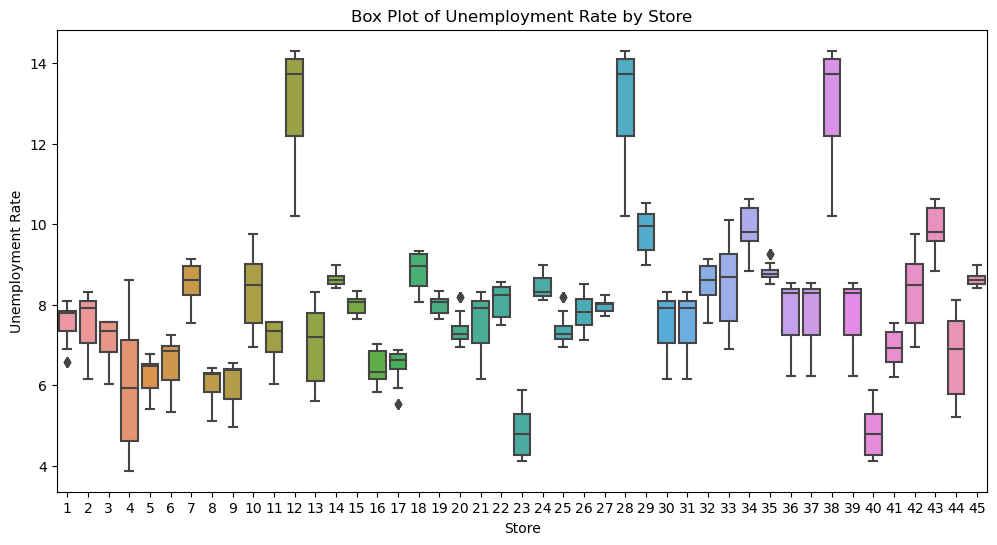

In [25]:
# Create box plot of unemployment rate by store
plt.figure(figsize=(12, 6))
sns.boxplot(x='Store', y='Unemployment', data=data)
plt.title('Box Plot of Unemployment Rate by Store')
plt.xlabel('Store')
plt.ylabel('Unemployment Rate')
plt.show()

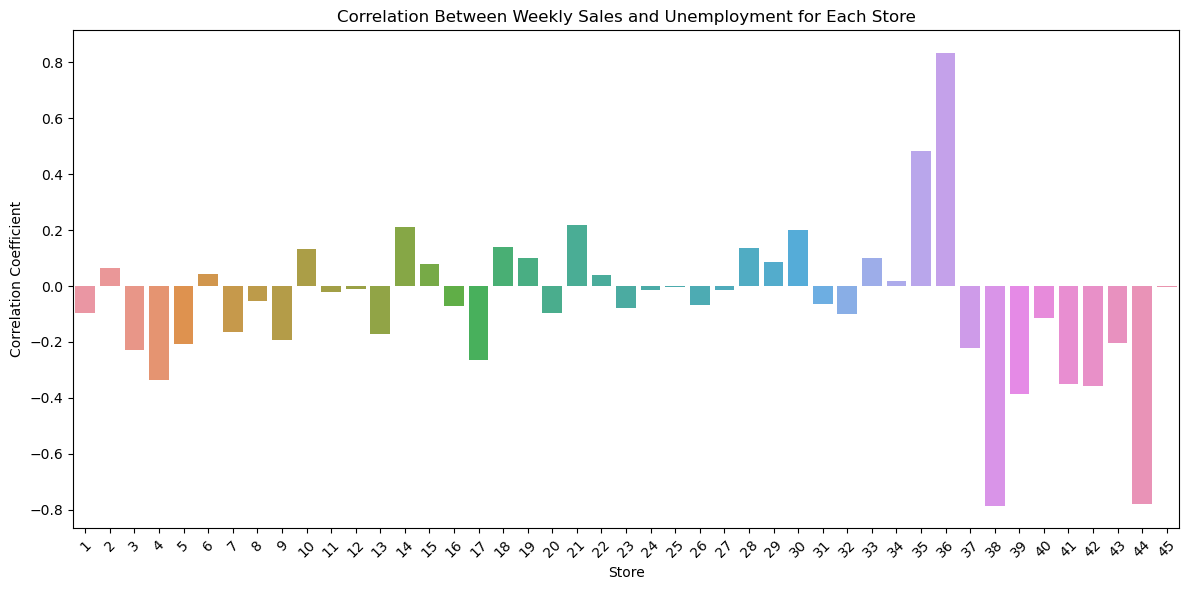

In [26]:
# Calculate correlation between weekly sales and unemployment rate for each store
store_correlation = data.groupby('Store')[['Weekly_Sales', 'Unemployment']].corr().iloc[0::2, -1]

# Reset index to make 'Store' a column
store_correlation = store_correlation.reset_index()

# Plot correlation coefficients
plt.figure(figsize=(12, 6))
sns.barplot(x='Store', y='Unemployment', data=store_correlation)
plt.title('Correlation Between Weekly Sales and Unemployment for Each Store')
plt.xlabel('Store')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# Ans 1)
- In examining the relationship between unemployment rates and weekly sales across Walmart stores, we find an overall correlation coefficient of -0.106176, indicating a very weak negative correlation. However, delving into store-specific correlations reveals nuanced patterns.

- Store No. 38 and 44 exhibit notably strong negative correlations with the unemployment rate, suggesting that as unemployment rates rise, weekly sales in these stores tend to decrease significantly. Conversely, stores like No. 2, 4, 18, 39, 41, 42, and 43 demonstrate weaker negative correlations with the unemployment rate. While not as pronounced as stores 38 and 44, these stores still show a tendency for lower sales during periods of higher unemployment.

- Though the observed correlations are not particularly robust, they do indicate some level of relationship between unemployment rates and weekly sales. This suggests that economic factors, such as unemployment, may play a role in influencing consumer behavior and purchasing patterns, albeit to varying degrees across different store locations.

## Q2) :- If the weekly sales show a seasonal trend, when and what could be the reason?

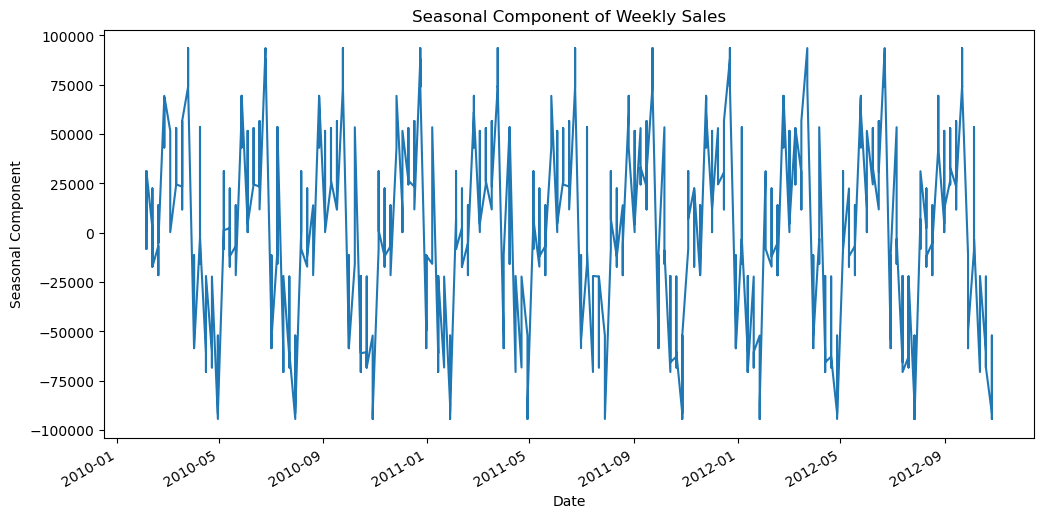

In [27]:
# Perform seasonal decomposition for weekly sales
result = seasonal_decompose(data['Weekly_Sales'], model='additive', period=52)  # Assuming weekly seasonality with a period of 52 weeks

# Plot the seasonal component
plt.figure(figsize=(12, 6))
result.seasonal.plot()
plt.title('Seasonal Component of Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Seasonal Component')
plt.show()

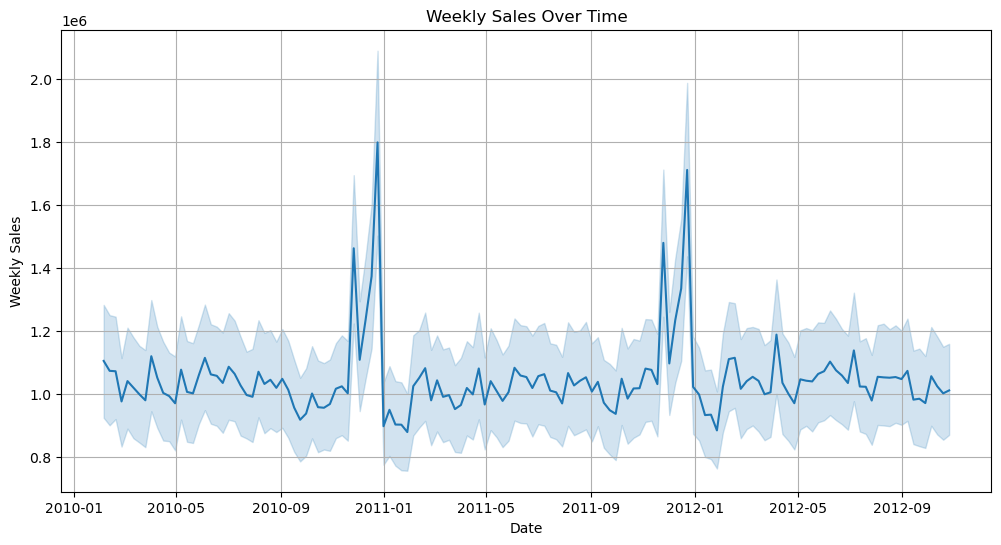

In [28]:

plt.figure(figsize=(12, 6))
sns.lineplot(x=data.index, y=data['Weekly_Sales'])
plt.title('Weekly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.show()

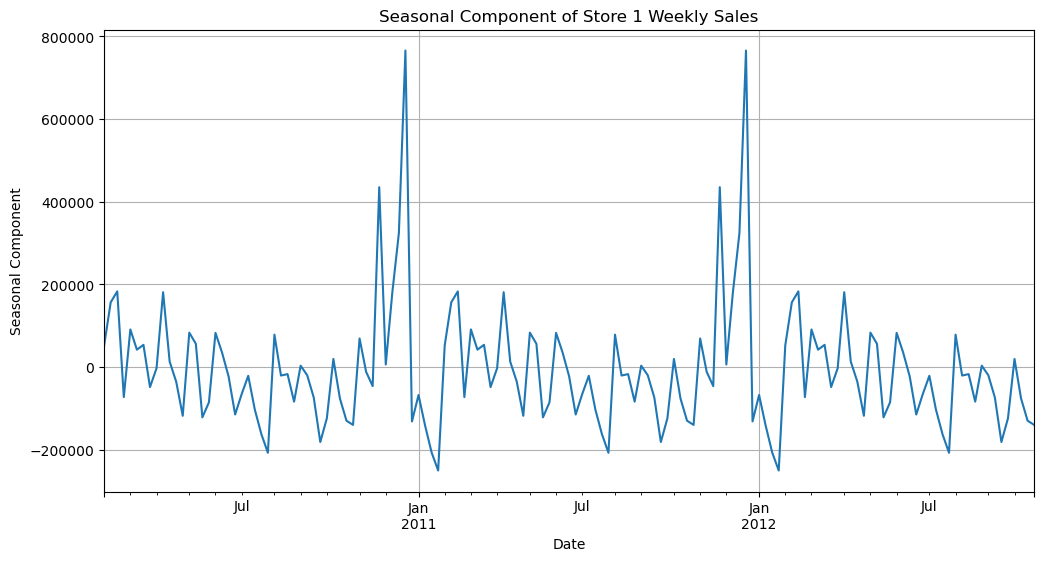

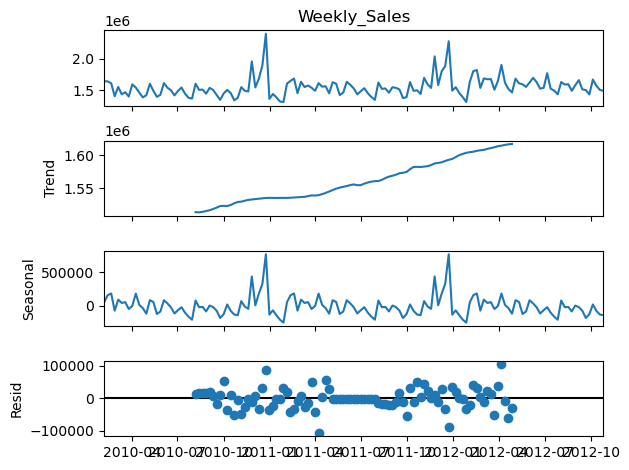

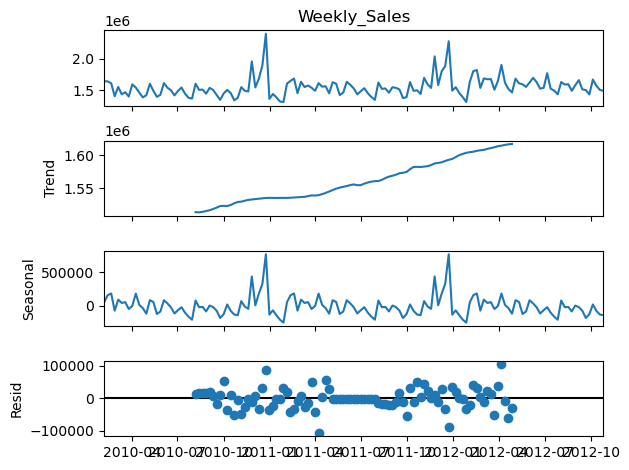

In [29]:
# Extract weekly sales data for Store 1
store1_sales = data[data['Store'] == 1]['Weekly_Sales']

# Perform seasonal decomposition for Store 1 weekly sales
result = seasonal_decompose(store1_sales, model='additive', period=52)  # Assuming weekly seasonality with a period of 52 weeks

# Plot the seasonal component of Store 1 weekly sales
plt.figure(figsize=(12, 6))
result.seasonal.plot()
plt.title('Seasonal Component of Store 1 Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Seasonal Component')
plt.grid(True)
plt.show()
result.plot()

## Ans 2) Yes, weekly sales show a seasonal trend in most of shops between November to January

The discernible seasonal trend observed in weekly sales across the majority of retail establishments occurs notably between November and January. This phenomenon can be attributed to several compelling factors:

- Firstly, the temporal span from late November through early January encapsulates pivotal festive occasions such as Thanksgiving, Christmas, and New Year's. During this period, consumers typically exhibit heightened expenditure tendencies, directed towards the acquisition of gifts, ornamental embellishments, and celebratory paraphernalia.

- Secondly, numerous retailers strategically orchestrate special promotional campaigns, incentivized discounts, and targeted sales events throughout the holiday season. These marketing maneuvers are tailored to allure and captivate shoppers, consequently fostering an uptick in consumer spending activity.

- Thirdly, the cultural tradition of gift-giving inherent to holiday festivities serves as a substantial catalyst for heightened retail transactions. The customary exchange of presents among individuals and households during this time engenders a surge in sales volume, particularly for merchandise categories perceived as quintessential gift items.

In sum, the seasonal fluctuations in weekly sales during the aforementioned months are underpinned by a confluence of sociocultural, marketing, and consumer behavior dynamics, collectively driving heightened commercial activity within the retail landscape.

## Q3) :- Does temperature affect the weekly sales in any manner?

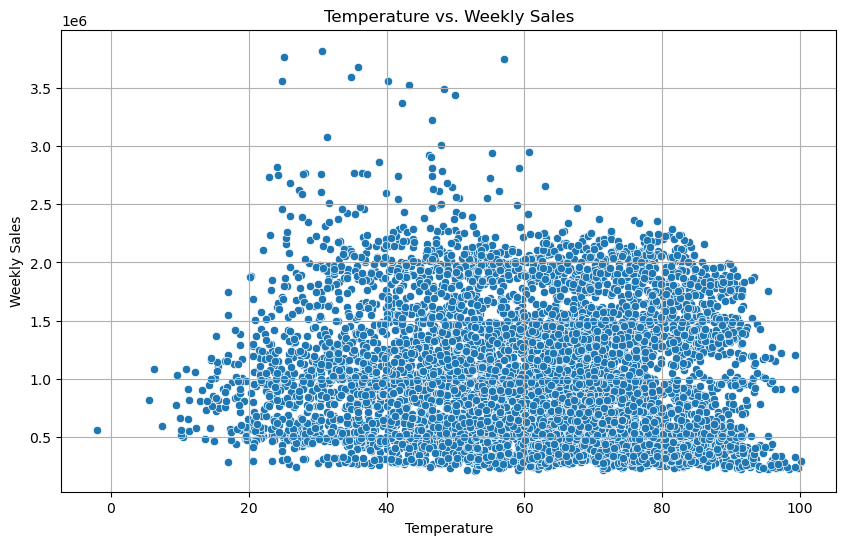

Correlation between temperature and weekly sales: -0.06381001317946962


In [30]:

# Plot scatter plot of temperature vs. weekly sales
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Temperature', y='Weekly_Sales', data=data)
plt.title('Temperature vs. Weekly Sales')
plt.xlabel('Temperature')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.show()

# Calculate correlation between temperature and weekly sales
correlation = data['Temperature'].corr(data['Weekly_Sales'])
print(f"Correlation between temperature and weekly sales: {correlation}")

## Ans 3)
The correlation coefficient between temperature and weekly sales is approximately -0.0638.

- This indicates a very weak negative correlation between temperature and weekly sales. In other words, there is a slight tendency for weekly sales to decrease slightly as temperature increases, and vice versa. However, the correlation is close to zero, suggesting that temperature has little to no linear relationship with weekly sales.

- It's important to note that correlation does not imply causation, and there may be other factors influencing weekly sales that are not captured by temperature alone. Further analysis may be needed to explore the relationship between temperature and weekly sales in more depth.

## Q4) :- How is the Consumer Price index affecting the weekly sales of various stores?

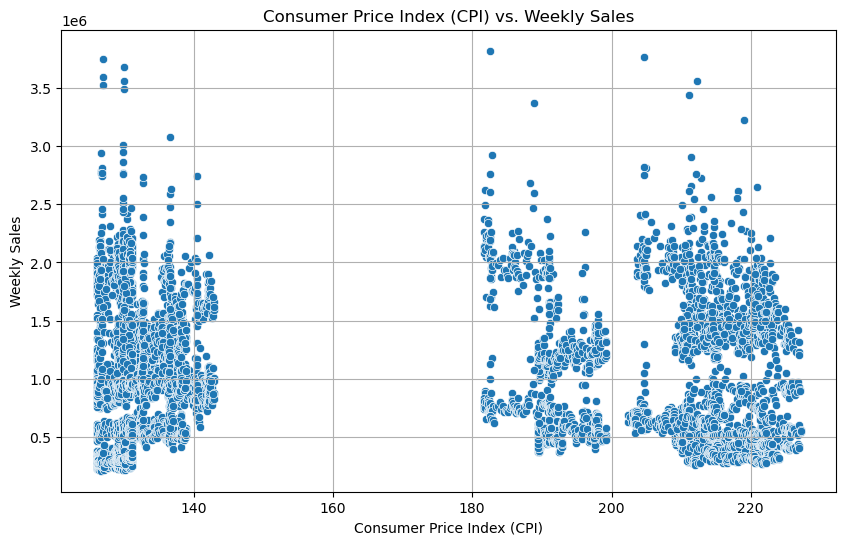

Correlation between CPI and weekly sales: -0.07263416204017631


In [31]:
# Plot scatter plot of CPI vs. weekly sales
plt.figure(figsize=(10, 6))
sns.scatterplot(x='CPI', y='Weekly_Sales', data=data)
plt.title('Consumer Price Index (CPI) vs. Weekly Sales')
plt.xlabel('Consumer Price Index (CPI)')
plt.ylabel('Weekly Sales')
plt.grid(True)
plt.show()

# Calculate correlation between CPI and weekly sales
correlation = data['CPI'].corr(data['Weekly_Sales'])
print(f"Correlation between CPI and weekly sales: {correlation}")

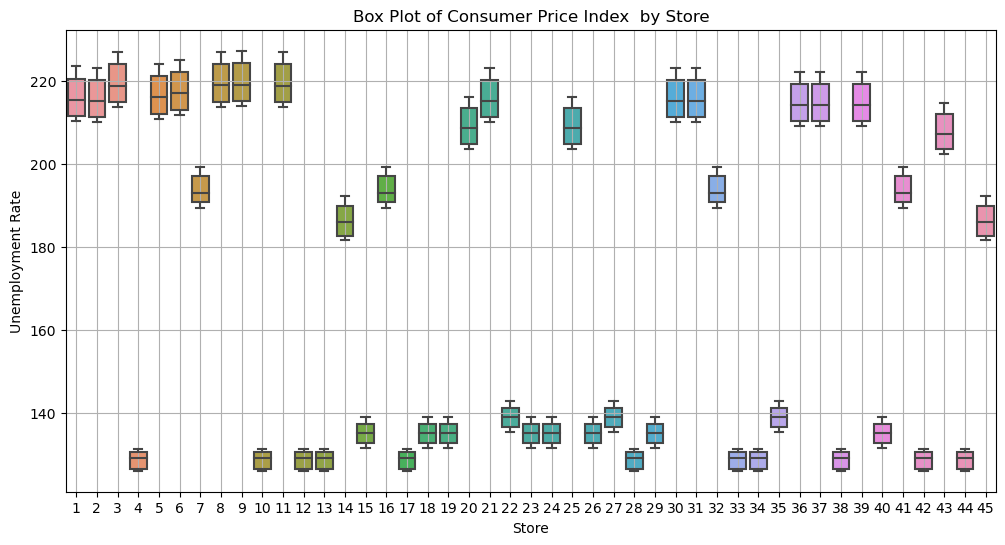

In [32]:
# Create box plot of unemployment rate by store
plt.figure(figsize=(12, 6))
sns.boxplot(x='Store', y='CPI', data=data)
plt.title('Box Plot of Consumer Price Index  by Store')
plt.xlabel('Store')
plt.ylabel('Unemployment Rate')
plt.grid(True)
plt.show()

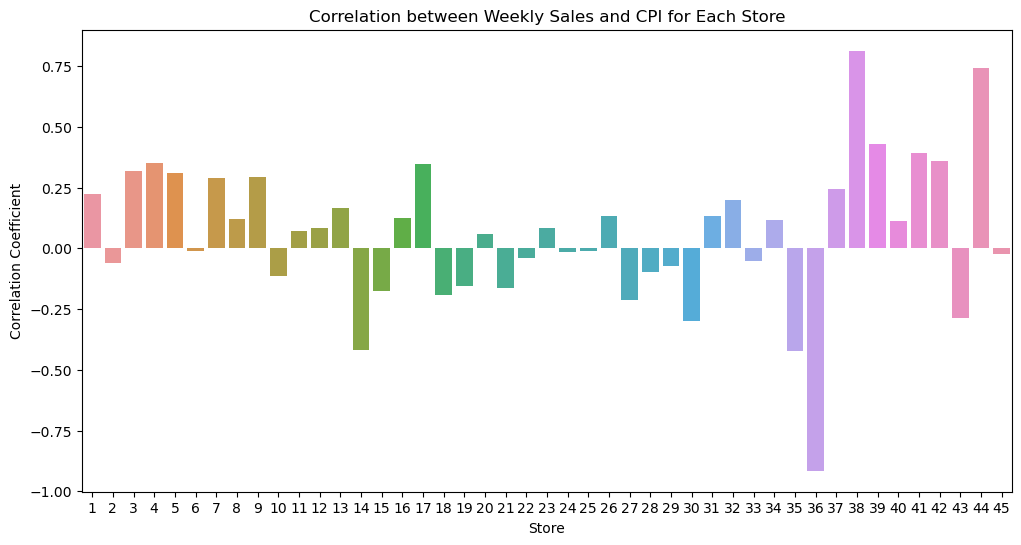

In [33]:
correlation_cpi_sales_by_store = data.groupby('Store')[['CPI', 'Weekly_Sales']].corr().iloc[0::2, -1].reset_index()
correlation_cpi_sales_by_store.drop(columns = 'level_1',inplace=True)
plt.figure(figsize=(12, 6))
sns.barplot(x = correlation_cpi_sales_by_store.Store,y = correlation_cpi_sales_by_store.Weekly_Sales)
plt.title('Correlation between Weekly Sales and CPI for Each Store')
plt.xlabel('Store')
plt.ylabel('Correlation Coefficient')
plt.show()

## Ans 4). 
- The overall correlation coefficient between the Consumer Price Index (CPI) and Weekly Sales is approximately -0.0726. This negative correlation suggests a weak inverse relationship between the Consumer Price Index and Weekly Sales. However, the correlation is relatively low, indicating that there isn't a strong linear relationship between these two variables.

- A negative correlation implies that as the Consumer Price Index decreases (or remains low), the Weekly Sales may slightly increase, and vice versa. The low magnitude of the correlation suggests that other factors beyond CPI are likely influencing Weekly Sales more significantly.

- However, upon closer examination, some individual stores demonstrate stronger correlations with CPI. Notably, stores such as 14, 36, 35, and 43 exhibit a pronounced negative correlation, suggesting that fluctuations in the Consumer Price Index have a notable impact on their weekly sales performance. Conversely, stores such as 38, 39, 41, 42, and 44 also demonstrate strong negative correlations, indicating a potential sensitivity to CPI variations, as depicted in graphical representations.

## Q5) :- Top performing stores according to the historical data.

Top 5 Performing Stores:
Store
20    3.013978e+08
4     2.995440e+08
14    2.889999e+08
13    2.865177e+08
2     2.753824e+08
Name: Weekly_Sales, dtype: float64


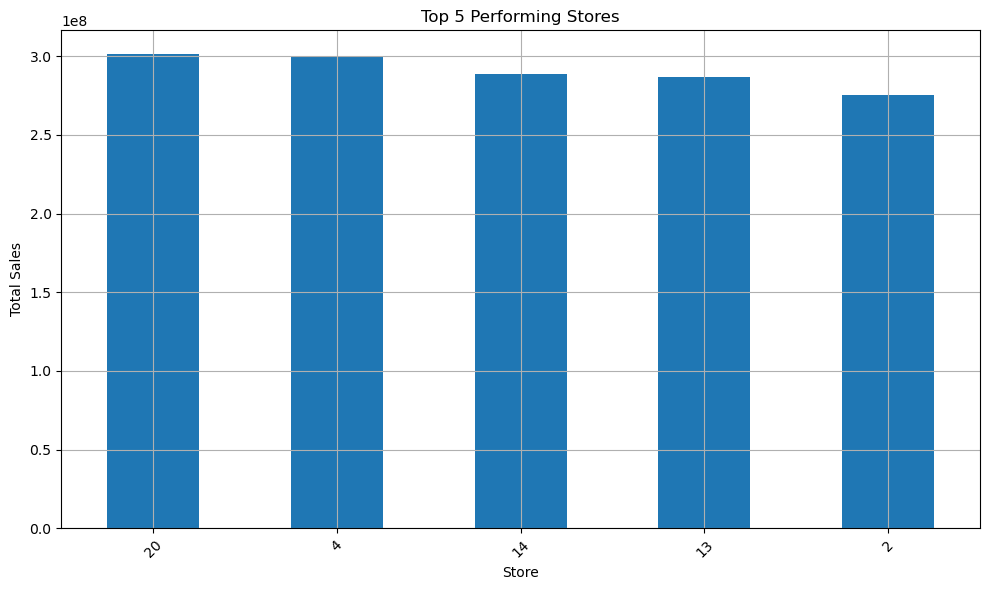

In [34]:
# Calculate total sales for each store
total_sales_per_store = data.groupby('Store')['Weekly_Sales'].sum()

# Sort stores by total sales in descending order
top_performing_stores = total_sales_per_store.sort_values(ascending=False)

# Print the top 5 performing stores
print("Top 5 Performing Stores:")
print(top_performing_stores.head())

# Plot the top 5 performing stores
plt.figure(figsize=(10, 6))
top_performing_stores.head().plot(kind='bar')
plt.title('Top 5 Performing Stores')
plt.xlabel('Store')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


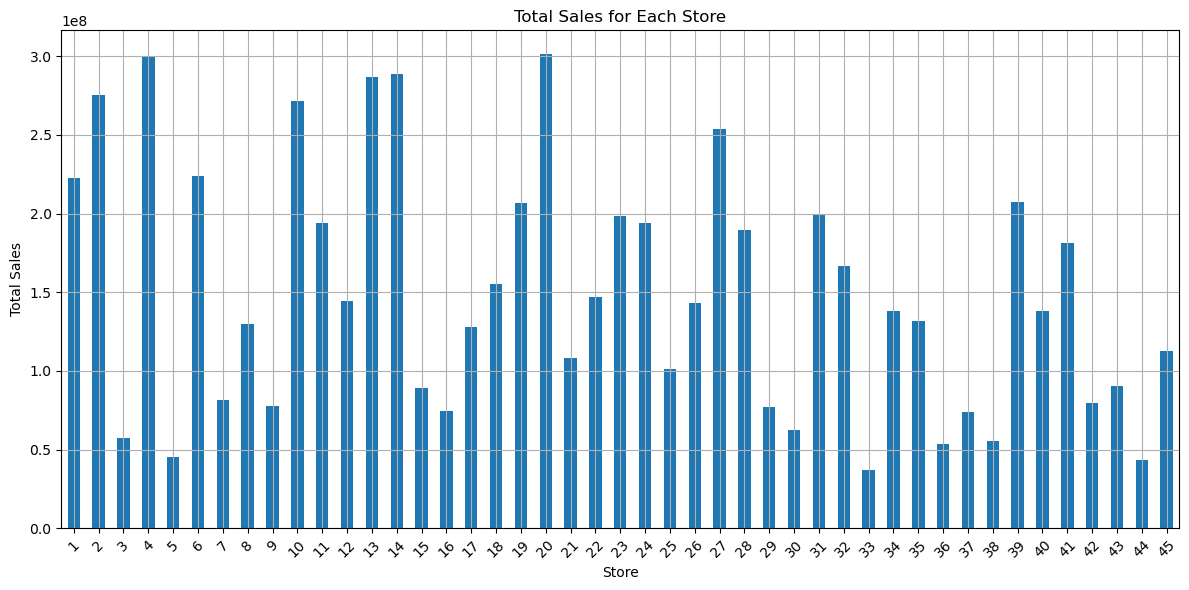

In [35]:
# Calculate total sales for each store
total_sales_per_store = data.groupby('Store')['Weekly_Sales'].sum()

# Plot total sales for each store
plt.figure(figsize=(12, 6))
total_sales_per_store.plot(kind='bar')
plt.title('Total Sales for Each Store')
plt.xlabel('Store')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## Ans 5). the above Graph we can see top selling stores are store no 2,4,13,14,20 according to sales that thay have made

## Q6) :- The worst performing store, and how significant is the difference between the highest and lowest performing stores ?

In [36]:
# Calculate total sales for each store
total_sales_per_store = data.groupby('Store')['Weekly_Sales'].sum()

# Find the worst performing store
worst_performing_store = total_sales_per_store.idxmin()
worst_performing_sales = total_sales_per_store.min()

# Find the best performing store
best_performing_store = total_sales_per_store.idxmax()
best_performing_sales = total_sales_per_store.max()

# Calculate the difference in total sales between the best and worst performing stores
sales_difference = best_performing_sales - worst_performing_sales

# Print the worst performing store and the difference in sales
print("Worst Performing Store:", worst_performing_store)
print("Difference in Sales (Best - Worst):", sales_difference)


Worst Performing Store: 33
Difference in Sales (Best - Worst): 264237570.49999997


## Ans 6) 
- The worst performing store is Store 33.

- The difference in total sales between the best performing store and the worst performing store is approximately $264,237,570.50.

- This significant difference underscores the disparity in sales performance across different stores within the dataset, highlighting the importance of analyzing and addressing factors that contribute to such variations in sales.

## Use predictive modeling techniques to forecast the sales for each store for the next 12 weeks

In [37]:
Store_1 = data[data['Store'] == 1].drop(columns=['Store','Holiday_Flag','Temperature','Fuel_Price','CPI','Unemployment'])

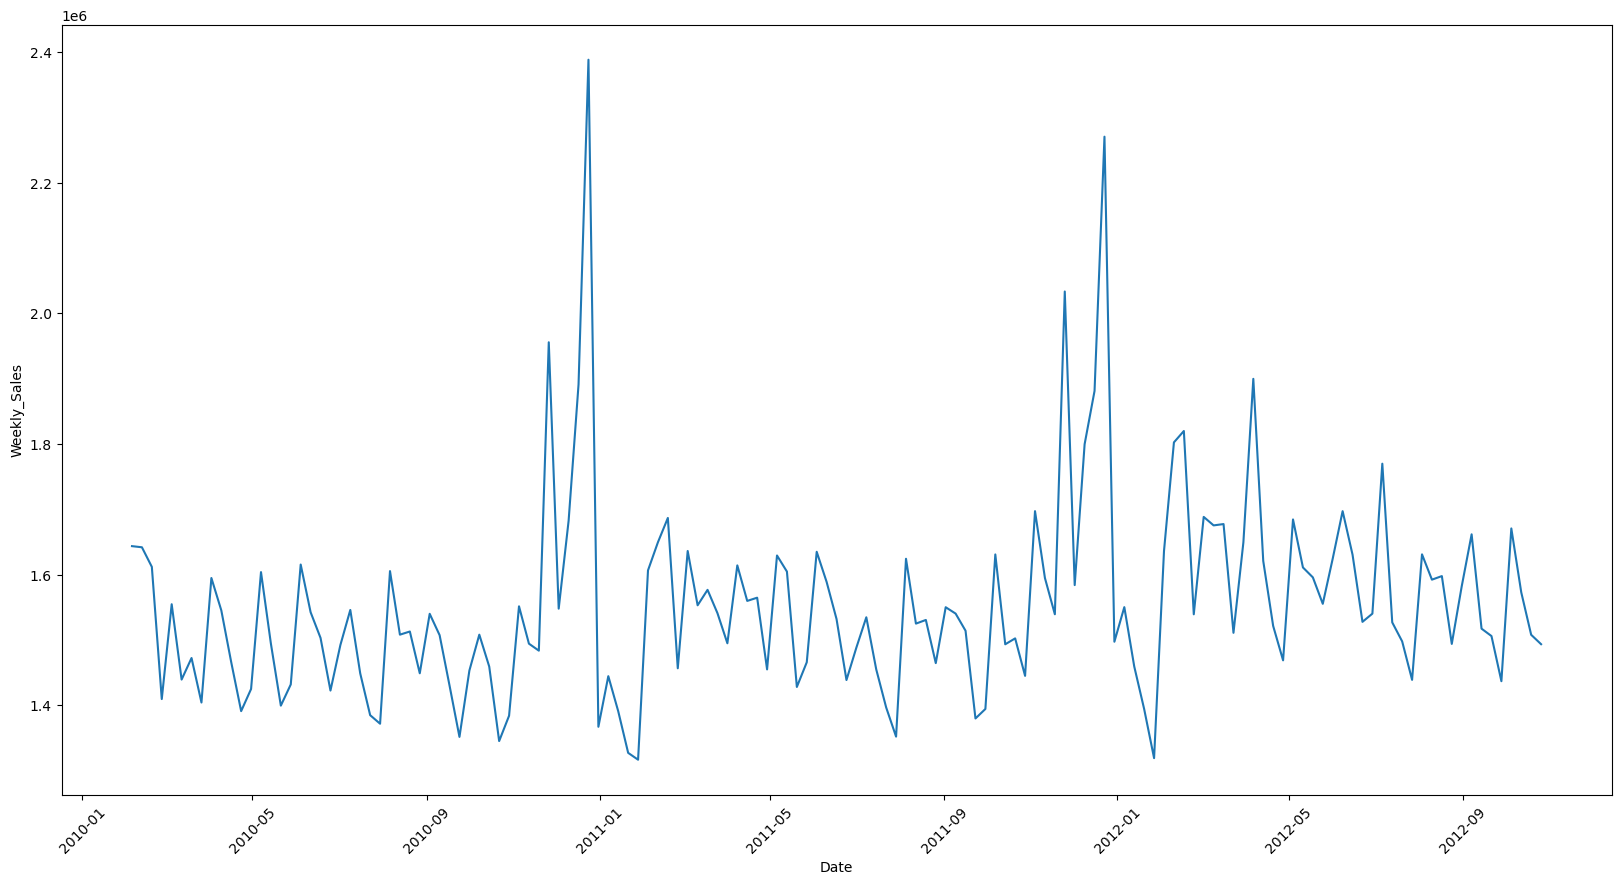

In [38]:
plt.figure(figsize=(20, 10))
sns.lineplot(Store_1['Weekly_Sales'])
plt.xticks(rotation=45)
plt.show()

In [39]:
Store_1.reset_index(drop=True, inplace=True)
Store_1.dropna(inplace=True)
Store_1 = Store_1.dropna()

In [40]:
Store_1

,Weekly_Sales
0,1643690.90
1,1641957.44
2,1611968.17
3,1409727.59
4,1554806.68
...,...
138,1437059.26
139,1670785.97
140,1573072.81
141,1508068.77


## We are taking rolling avg of three months to check data is stationary or not

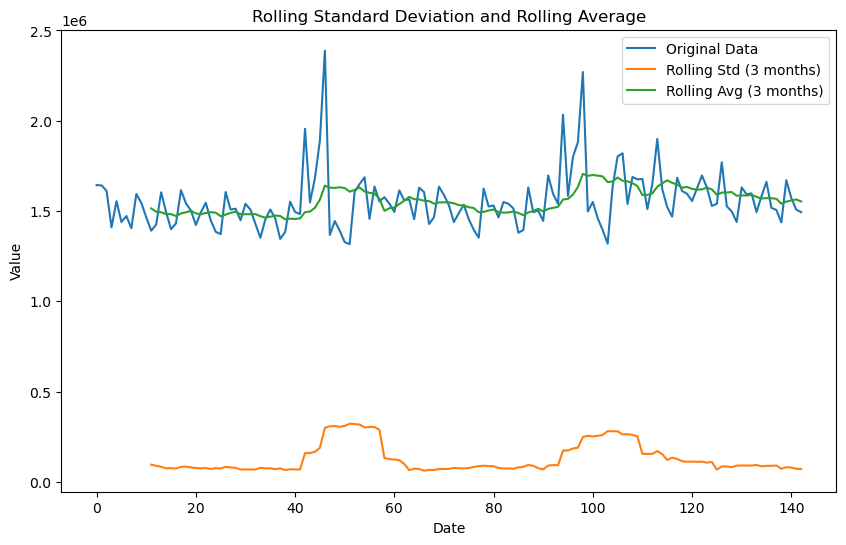

In [41]:
# Calculate rolling standard deviation and rolling average for three months
rolling_std = Store_1.rolling(window=12).std()  
rolling_avg = Store_1.rolling(window=12).mean()  

# Plot the rolling standard deviation and rolling average
plt.figure(figsize=(10, 6))
plt.plot(Store_1.index, Store_1['Weekly_Sales'], label='Original Data')
plt.plot(Store_1.index, rolling_std, label='Rolling Std (3 months)')
plt.plot(Store_1.index, rolling_avg, label='Rolling Avg (3 months)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Rolling Standard Deviation and Rolling Average')
plt.legend()
plt.show()

 ## We can see data is not stationary as mean and std is fluctuating so we will take log of weekly sales and then will calculate again rolling mean of that log values and then will subtract that log_rolling_mean from log_weekly_sales

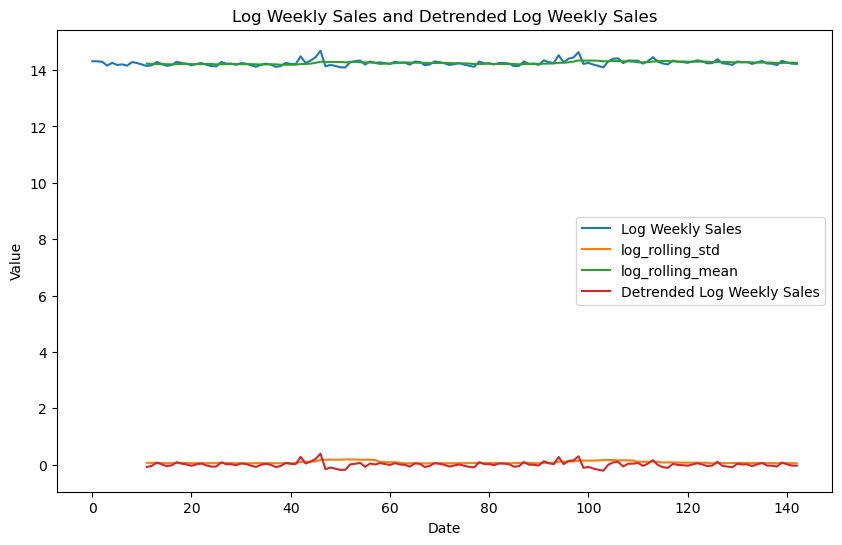

In [42]:
# Take the logarithm of the weekly sales
log_weekly_sales = np.log(Store_1)

# Calculate the rolling mean of the logarithm values
log_rolling_mean = log_weekly_sales.rolling(window=12).mean()
log_rolling_std = log_weekly_sales.rolling(window=12).std()

# Drop NaN values from log_weekly_sales
log_weekly_sales = log_weekly_sales[log_weekly_sales.index.isin(log_rolling_mean.index)]

# Subtract the rolling mean from the logarithm values to detrend the data
detrended_log_sales = log_weekly_sales - log_rolling_mean

# Plot the original log weekly sales and detrended log weekly sales
plt.figure(figsize=(10, 6))
plt.plot(Store_1.index, log_weekly_sales, label='Log Weekly Sales')
plt.plot(Store_1.index, log_rolling_std, label='log_rolling_std')
plt.plot(Store_1.index, log_rolling_mean, label='log_rolling_mean')
plt.plot(Store_1.index, detrended_log_sales, label='Detrended Log Weekly Sales')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Log Weekly Sales and Detrended Log Weekly Sales')
plt.legend()
plt.show()


In [43]:

detrended_log_sales=detrended_log_sales.dropna()
Store_1.reset_index(drop=True, inplace=True)
detrended_log_sales.head()
detrended_log_sales.shape

(132, 1)

In [44]:
detrended_log_sales

,Weekly_Sales
11,-0.083201
12,-0.047274
13,0.072908
14,0.008380
15,-0.056418
...,...
138,-0.068398
139,0.074799
140,0.010458
141,-0.035643


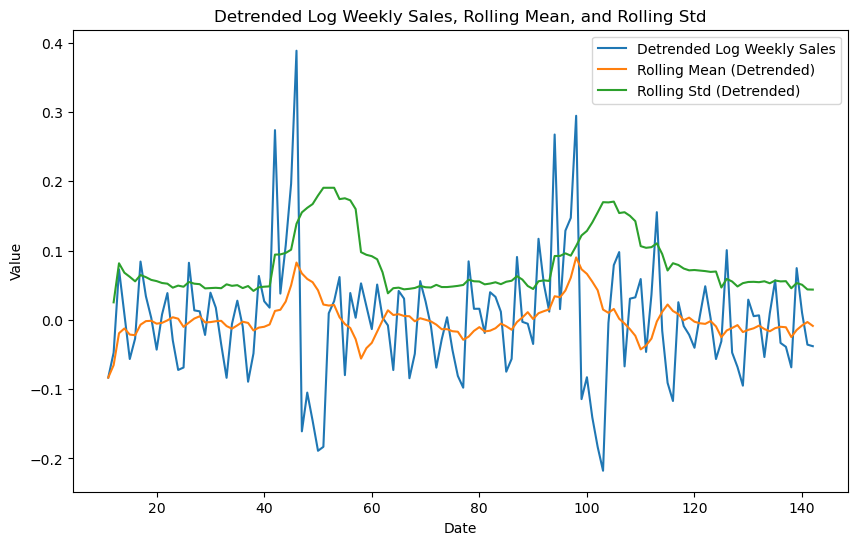

In [45]:
# Calculate rolling mean and rolling standard deviation of detrended log weekly sales
detrended_log_rolling_mean = detrended_log_sales.rolling(window=12, min_periods=1).mean()
detrended_log_rolling_std = detrended_log_sales.rolling(window=12, min_periods=1).std()

# Plot the detrended log weekly sales, rolling mean, and rolling standard deviation
plt.figure(figsize=(10, 6))
plt.plot( detrended_log_sales, label='Detrended Log Weekly Sales')
plt.plot( detrended_log_rolling_mean, label='Rolling Mean (Detrended)')
plt.plot( detrended_log_rolling_std, label='Rolling Std (Detrended)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Detrended Log Weekly Sales, Rolling Mean, and Rolling Std')
plt.legend()
plt.show()


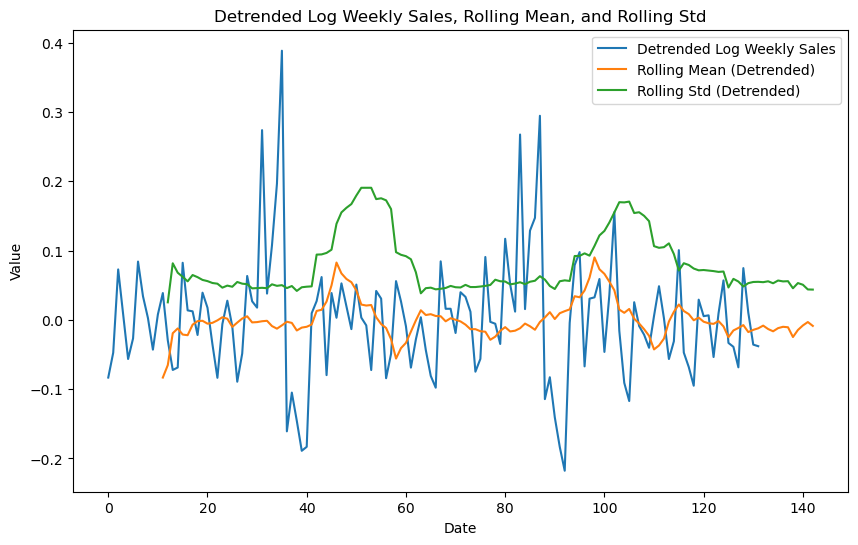

In [46]:
# Convert DataFrame column to a one-dimensional array
detrended_log_sales_array = detrended_log_sales.squeeze().values

# Plot the detrended log weekly sales, rolling mean, and rolling standard deviation
plt.figure(figsize=(10, 6))
plt.plot(detrended_log_sales_array, label='Detrended Log Weekly Sales')
plt.plot(detrended_log_rolling_mean, label='Rolling Mean (Detrended)')
plt.plot(detrended_log_rolling_std, label='Rolling Std (Detrended)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Detrended Log Weekly Sales, Rolling Mean, and Rolling Std')
plt.legend()
plt.show()


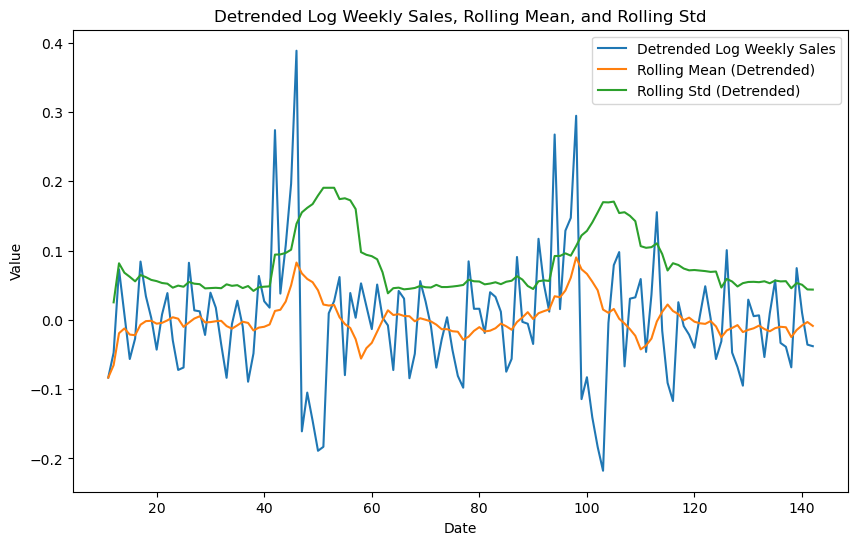

In [47]:
# Calculate rolling mean and rolling standard deviation of detrended log weekly sales
detrended_log_rolling_mean = detrended_log_sales.rolling(window=12, min_periods=1).mean()
detrended_log_rolling_std = detrended_log_sales.rolling(window=12, min_periods=1).std()

# Plot the detrended log weekly sales, rolling mean, and rolling standard deviation
plt.figure(figsize=(10, 6))
plt.plot(detrended_log_sales, label='Detrended Log Weekly Sales')
plt.plot(detrended_log_rolling_mean, label='Rolling Mean (Detrended)')
plt.plot(detrended_log_rolling_std, label='Rolling Std (Detrended)')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Detrended Log Weekly Sales, Rolling Mean, and Rolling Std')
plt.legend()
plt.show()


## here we are checking seasonality, trend, randomness of our processed data

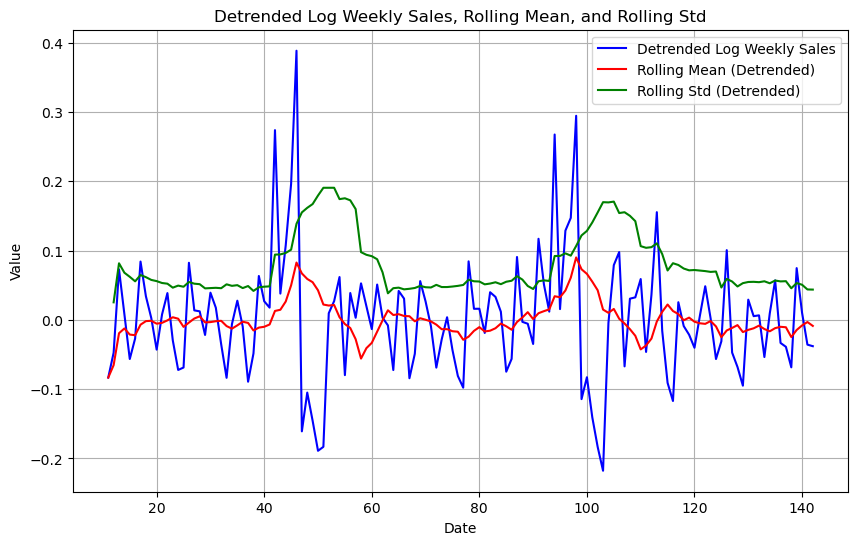

In [48]:
# Plot detrended log weekly sales, rolling mean, and rolling standard deviation
plt.figure(figsize=(10, 6))
plt.plot(detrended_log_sales.index, detrended_log_sales, label='Detrended Log Weekly Sales', color='blue')
plt.plot(detrended_log_rolling_mean.index, detrended_log_rolling_mean, label='Rolling Mean (Detrended)', color='red')
plt.plot(detrended_log_rolling_std.index, detrended_log_rolling_std, label='Rolling Std (Detrended)', color='green')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Detrended Log Weekly Sales, Rolling Mean, and Rolling Std')
plt.legend()
plt.grid(True)
plt.show()


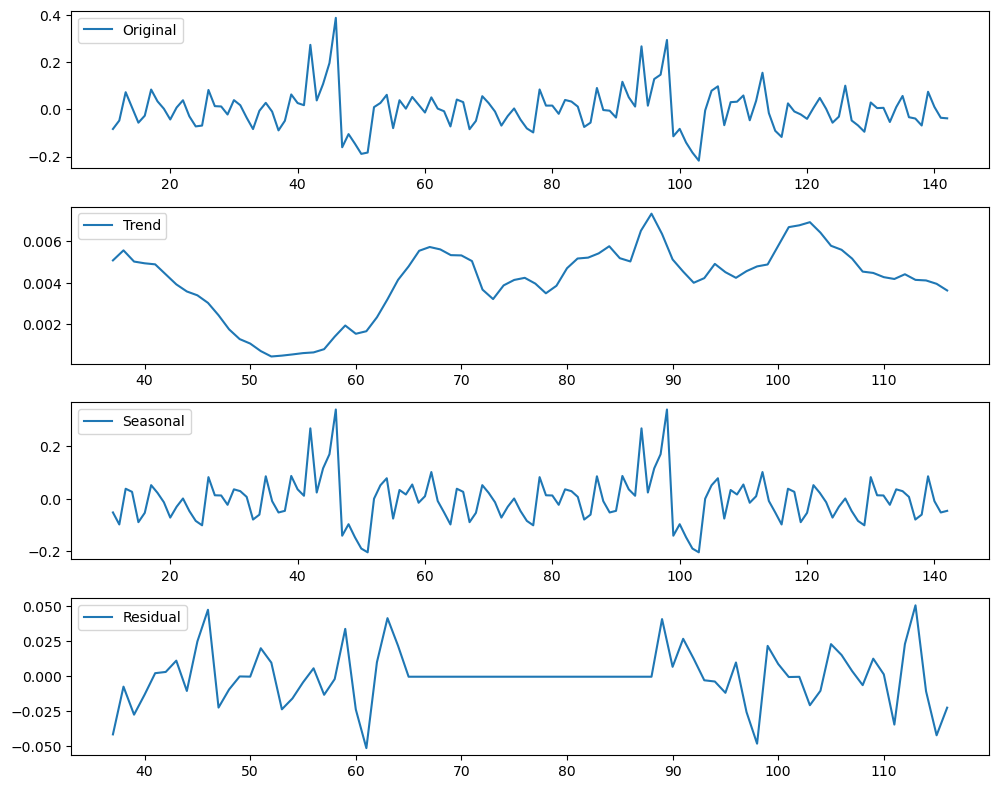

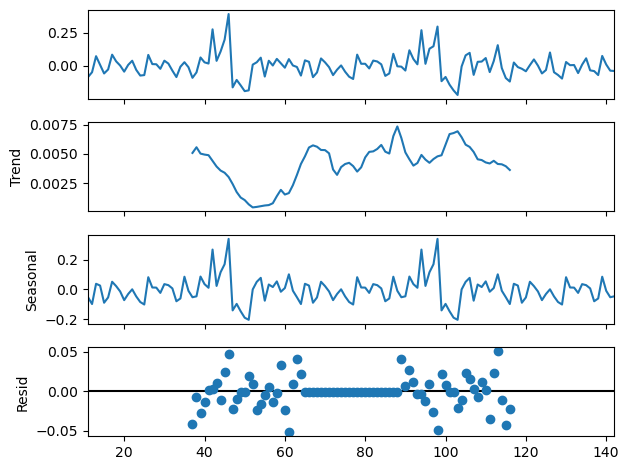

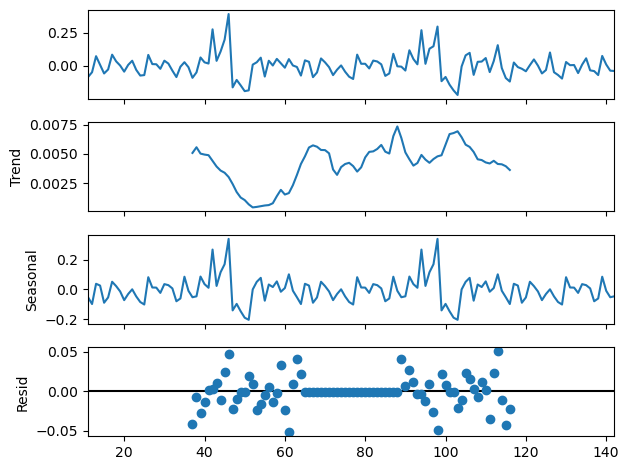

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(detrended_log_sales, period=52)

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
ax1.plot(detrended_log_sales, label='Original')
ax1.legend(loc='upper left')
ax2.plot(decomposition.trend, label='Trend')
ax2.legend(loc='upper left')
ax3.plot(decomposition.seasonal, label='Seasonal')
ax3.legend(loc='upper left')
ax4.plot(decomposition.resid, label='Residual')
ax4.legend(loc='upper left')
plt.tight_layout()
plt.show()
decomposition.plot()


## Checking stationarity using statistical method named dickey-fuller test

In [50]:
# Perform Dickey-Fuller test on detrended log weekly sales
result = adfuller(detrended_log_sales)

# Extract and print the test statistic and p-value
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key}: {value}')


ADF Statistic: -6.113651018315903
p-value: 9.204565497005554e-08
Critical Values:
   1%: -3.482920063655088
   5%: -2.884580323367261
   10%: -2.5790575441750883


### Based on the results of the Augmented Dickey-Fuller (ADF) test:

ADF Statistic: -6.113651018315903
p-value: 9.204565497005554e-08 (approximately 0)
- The null hypothesis of the ADF test is that the time series has a unit root (it is non-stationary). Since the p-value is much less than 0.05 (the common significance level), we can reject the null hypothesis. Therefore, we have evidence to suggest that the detrended log weekly sales data is stationary.

Additionally, we can compare the ADF statistic to the critical values at various significance levels:

- At the 1% significance level, the critical value is -3.482920063655088.
- At the 5% significance level, the critical value is -2.884580323367261.
- At the 10% significance level, the critical value is -2.5790575441750883.
Since the ADF statistic is lower than all the critical values, we can reject the null hypothesis and conclude that the detrended log weekly sales data is stationary with a high degree of confidence.

This suggests that the detrended log weekly sales data does not have a unit root and is stationary, which is a desirable property for many time series analysis techniques.

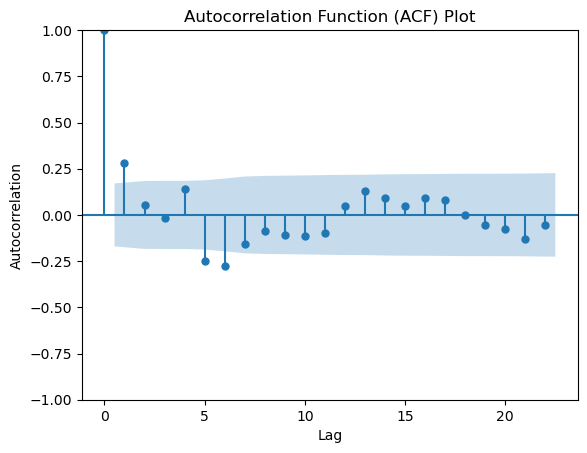

In [51]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot autocorrelation function
plot_acf(detrended_log_sales.dropna())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot')
plt.show()


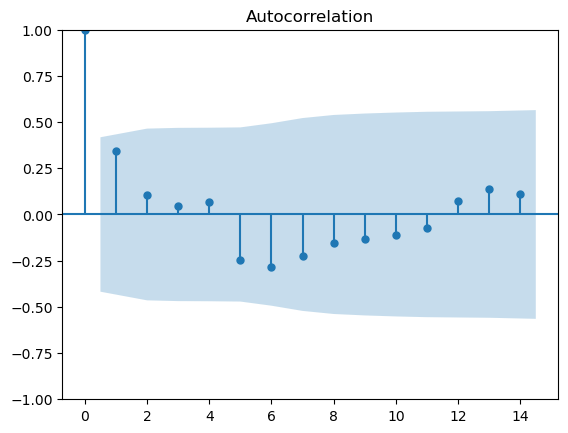

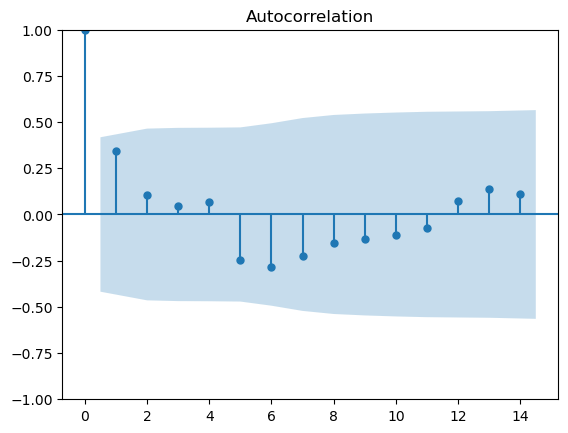

In [52]:
acf_plot=acf(detrended_log_sales.dropna())
plot_acf(acf_plot)

In [53]:
acf_plot

array([ 1.        ,  0.28323536,  0.05434626, -0.01871149,  0.14232513,
       -0.25018221, -0.2752769 , -0.15782897, -0.08790136, -0.10736686,
       -0.11612204, -0.09844943,  0.04828773,  0.12699146,  0.09229526,
        0.04909011,  0.09136059,  0.07854934,  0.00140915, -0.05276892,
       -0.07599617, -0.13190373])

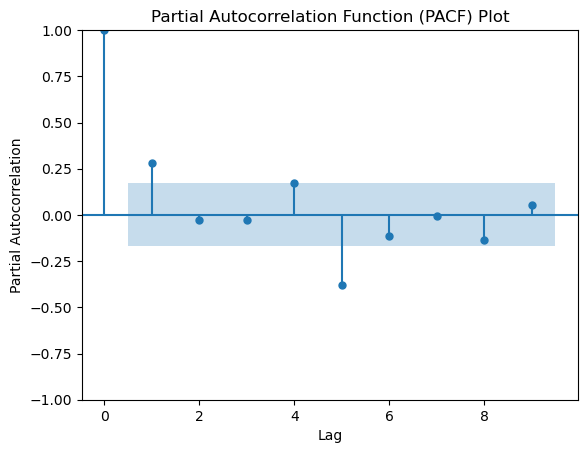

In [54]:
from statsmodels.graphics.tsaplots import plot_pacf

# Plot partial autocorrelation function
plot_pacf(detrended_log_sales.dropna(), lags=9)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF) Plot')
plt.show()


In [55]:
detrended_log_sales.shape

(132, 1)

In [56]:
train = detrended_log_sales.iloc[:120]
test = detrended_log_sales.iloc[120:]

## ARIMA Model 

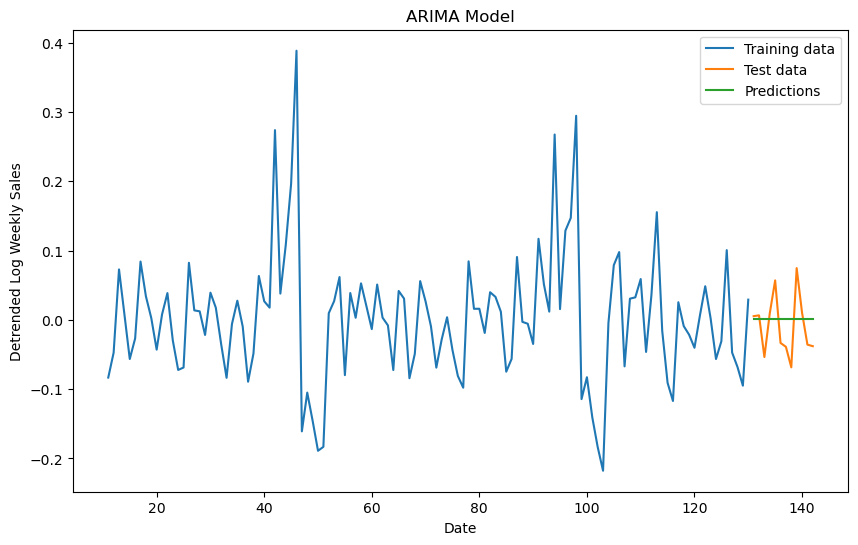

In [57]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Define the ARIMA model parameters (p, d, q)
p = 1  # Autoregressive (AR) order
d = 1  # Integrated (I) order (degree of differencing)
q = 1  # Moving average (MA) order

# Create and fit the ARIMA model
model = ARIMA(train, order=(p, d, q))
arima_result = model.fit()

# Generate predictions for the test set
predictions = arima_result.predict(start=test.index[0], end=test.index[-1], typ='levels')

# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(train, label='Training data')
plt.plot(test, label='Test data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Detrended Log Weekly Sales')
plt.title('ARIMA Model')
plt.legend()
plt.show()


## SERIMAX Model

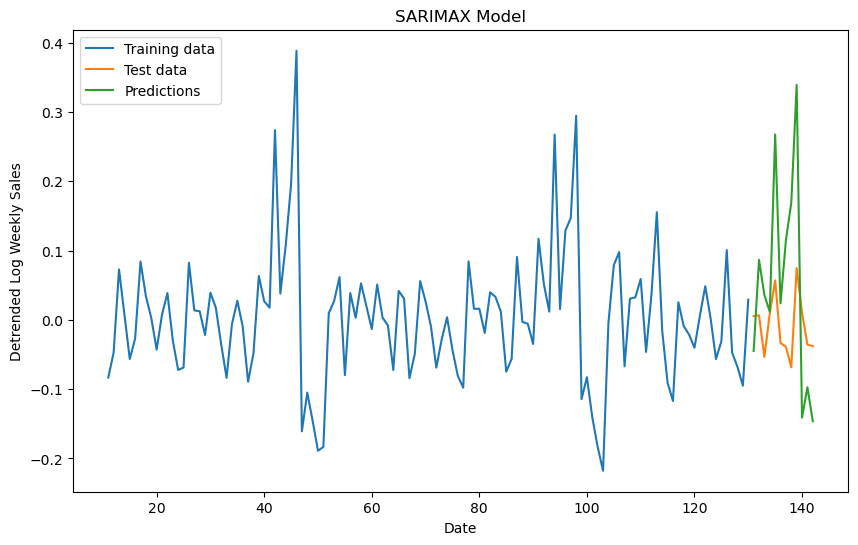

In [58]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Define the SARIMAX model parameters (p, d, q, P, D, Q, s)
p = 1  # Autoregressive (AR) order
d = 1  # Integrated (I) order (degree of differencing)
q = 1  # Moving average (MA) order
P = 1  # Seasonal autoregressive (SAR) order
D = 1  # Seasonal integrated (SI) order (degree of differencing)
Q = 1  # Seasonal moving average (SMA) order
s = 52  # Seasonal period

# Create and fit the SARIMAX model
model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, s))
sarimax_result = model.fit()

# Generate predictions for the test set
predictions = sarimax_result.predict(start=test.index[0], end=test.index[-1], typ='levels')

# Plot the actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(train, label='Training data')
plt.plot(test, label='Test data')
plt.plot(predictions, label='Predictions')
plt.xlabel('Date')
plt.ylabel('Detrended Log Weekly Sales')
plt.title('SARIMAX Model')
plt.legend()
plt.show()


## Predicting sales for next 12 weeks

Forecasted sales for the next 12 weeks:
120    0.007079
121    0.010696
122   -0.023436
123    0.036549
124    0.022195
125   -0.015248
126   -0.082316
127   -0.033790
128    0.055672
129   -0.009295
130   -0.051159
131   -0.044766
Name: predicted_mean, dtype: float64


<Axes: >

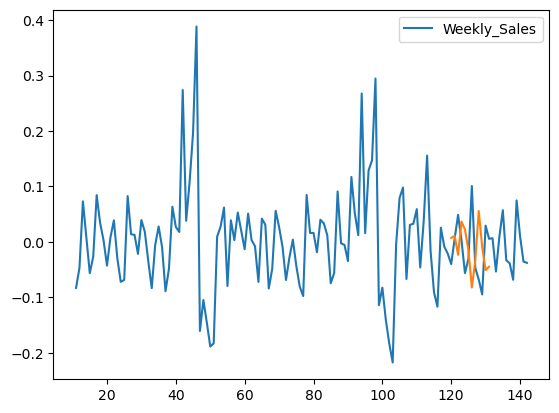

In [59]:
# Generate forecasts for the next 12 weeks
forecast = sarimax_result.forecast(steps=12)

# Print the forecasted sales for the next 12 weeks
print("Forecasted sales for the next 12 weeks:")
print(forecast)
detrended_log_sales.plot()
forecast.plot()

## Calculating erros between test data and predicted data

In [60]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test, predictions)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)


Mean Absolute Error (MAE): 0.1222703309873252
Mean Squared Error (MSE): 0.0211004576008912
Root Mean Squared Error (RMSE): 0.1452599655820254
